Three footprints:
- One using K_D
- One using K_\mathrm{on} and K_\mathrm{off}
- One that breaks an "interesting" edge

In [1]:
## processing
import numpy as np
import pandas as pd
from Bio import SeqIO

## custom_package
import tregs

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [6]:
# CRP binding site
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'
# energy matrix obtained from Fig 3. of Kinney et al., 2010 (https://www.pnas.org/doi/full/10.1073/pnas.1004290107)
# elements expressed in kcal/mol (1 kcal/mol = 1.62kbT)

crp_emat_raw = pd.read_table('../../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T * 1.62

### Simple activation using the graph theory approach

In [7]:
def simact_graph(p_seq, a_seq, c_p, c_a, p_emat, a_emat,
                 ep_wt, ea_wt, e_ap,
                 k_on=0.1, C_N=10**(-2)):
    
    k_E_P = k_on
    k_E_A = k_on
    k_A_AP = k_on
    k_P_AP = k_on

    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_a = tregs.simulate.get_weight(a_seq, a_emat, e_wt=ea_wt)
    
    k_P_E = k_E_P * C_N * w_p
    k_A_E = k_E_A * C_N * w_a
    k_AP_P = k_P_AP * C_N * w_a * np.exp(-e_ap)
    k_AP_A = k_A_AP * C_N * w_p * np.exp(-e_ap)

    # weights of each vertex
    rho_E = k_A_E * k_P_E * k_AP_P
    rho_E += k_A_AP * k_AP_P * k_P_E * c_p
    rho_E += k_P_E * k_AP_A * k_A_E
    rho_E += k_A_E * k_AP_A * k_P_AP * c_a

    rho_A = k_AP_P * k_P_E * k_E_A * c_a
    rho_A += k_E_P * k_P_AP * k_AP_A * c_a * c_p
    rho_A += k_P_E * k_E_A * k_AP_A * c_a
    rho_A += k_P_AP * k_AP_A * k_E_A * c_a**2

    rho_P = k_A_E * k_E_P * k_AP_P * c_p
    rho_P += k_E_P * k_A_AP * k_AP_P * c_p**2
    rho_P += k_AP_A * k_A_E * k_E_P * c_p
    rho_P += k_E_A * k_A_AP * k_AP_P * c_a * c_p

    rho_AP = k_A_E * k_E_P * k_P_AP * c_a * c_p
    rho_AP += k_E_P * k_P_AP * k_A_AP * c_a * c_p**2
    rho_AP += k_P_E * k_E_A * k_A_AP * c_a * c_p
    rho_AP += k_E_A * k_A_AP * k_P_AP * c_a**2 * c_p

    p_A = rho_A / (rho_A + rho_E + rho_P + rho_AP)
    p_AP = rho_AP / (rho_A + rho_E + rho_P + rho_AP)

    return p_A + p_AP

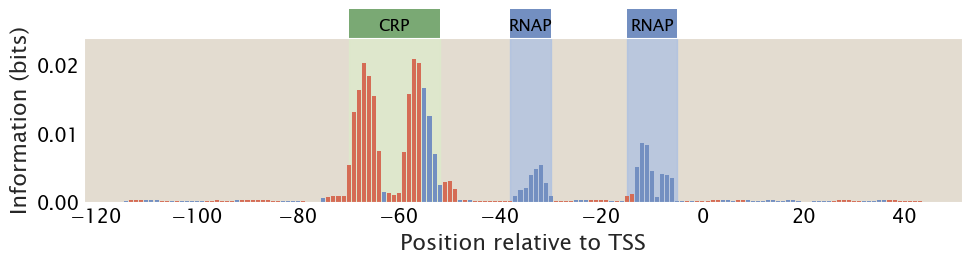

In [22]:
# copy numbers
c_a = 50
c_p = 5000

# binding energies
ep_wt = -7
ea_wt = -7
e_ap = -12

df = tregs.simulate.sim(promoter, simact_graph, [rnap_site, crp_site], 
                        *[c_p, c_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False)